<hr />
<h1 align="center">Using ArcticDB for equity analytics: a worked example</h1>
<center><img src="https://raw.githubusercontent.com/man-group/ArcticDB/master/static/ArcticDBCropped.png" alt="ArcticDB Logo" width="400">
<hr />

### A Simple Workflow for Equity Price Timeseries

In this notebook we:

* Source historical tech equity and S&P 500 prices from Yahoo! using the yfinance package
* Store 10 years of daily price raw data in a temporary local ArcticDB library set up in the notebook
* The data sourcing is broken into two steps: an initial load of history then an update for recent prices
* This suggests a typical system workflow: an initial backfill and daily update with recent data
* Take Adjusted Close prices, remove missing data and calculate returns. Then save this to library
* Read the clean returns and use them to calculate rolling beta against the S&P 500 for the stocks

### Notice: This notebook sources data from Yahoo!

Please read Yahoo terms here before using it

https://policies.yahoo.com/us/en/yahoo/terms/index.htm

### Installs and Imports

In [1]:
!pip install arcticdb yfinance

In [2]:
import arcticdb as adb
import yfinance as yf
import pandas as pd
from typing import List, Tuple
from datetime import datetime 
import matplotlib.pyplot as plt 

### ArcticDB Setup

In [3]:
arctic = adb.Arctic("lmdb://arcticdb_equity")
lib = arctic.get_library('demo', create_if_missing=True)

### Source Historical Prices from Yahoo!

In [4]:
start = datetime(2013, 1, 1) 
end = datetime(2022, 12, 31)
freq = '1d'
symbols = {
    '^GSPC': 'S&P 500',
    'AAPL': 'Apple',
    'MSFT': 'Microsoft',
    'GOOG': 'Google',
    'AMZN': 'Amazon',
    'NVDA': 'Nvidia',
    'META': 'Meta',
    'TSLA': 'Tesla',
    'TSM': 'TSMC',
    'TCEHY': 'Tencent',
    '005930.KS': 'Samsung',
    'ORCL': 'Oracle',
    'ADBE': 'Adobe',
    'ASML': 'ASML',
    'CSCO': 'Cisco'
}

In [5]:
hist = yf.download(list(symbols.keys()), interval=freq, start=start, end=end)

[*********************100%%**********************]  15 of 15 completed


In [6]:
# the column levels[0] are the fields for each stock
print(hist.columns.levels[0])
hist['Volume'].head(5)

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


,005930.KS,AAPL,ADBE,AMZN,ASML,CSCO,GOOG,META,MSFT,NVDA,ORCL,TCEHY,TSLA,TSM,^GSPC
Date,,,,,,,,,,,,,,,
2013-01-02,11449650.0,560518000.0,6483800.0,65420000.0,1824000.0,40304500.0,102033017.0,69846400.0,52899300.0,47883600.0,33758400.0,362500.0,17922000.0,10226100.0,4.202600e+09
2013-01-03,14227400.0,352965200.0,3906000.0,55018000.0,1725400.0,50603500.0,93075567.0,63140600.0,48294400.0,29888800.0,21819500.0,355000.0,11130000.0,13148600.0,3.829730e+09
2013-01-04,12999800.0,594333600.0,3809300.0,37484000.0,3170800.0,36378900.0,110954331.0,72715400.0,52521100.0,52496800.0,21687300.0,101000.0,10110000.0,7464200.0,3.424290e+09
2013-01-07,12610950.0,484156400.0,3632100.0,98200000.0,2066100.0,30790700.0,66476239.0,83781800.0,37110400.0,61073200.0,14008300.0,83000.0,6630000.0,9429900.0,3.304970e+09
2013-01-08,13822250.0,458707200.0,3080900.0,60214000.0,1182400.0,33218100.0,67295297.0,45871300.0,44703100.0,46642400.0,17408900.0,49000.0,19260000.0,8112900.0,3.601600e+09


### Write the Data to the Library

Currently ArcticDB cannot store multi-level column dataframes directly, so we transform the columns to strings for storage.

In [7]:
# simple functions for flattening and reinflating multi-level columns

def join_tuples(tuples: List[Tuple[str]], delim: str='|') -> List[str]:
    return [delim.join(i) for i in tuples]
    
def split_joined(joined: List[str], delim: str='|') -> List[Tuple[str]]:
    return [tuple(i.split(delim)) for i in joined]

def flatten_cols(df):
    if not isinstance(df.columns, pd.MultiIndex):
        return df.columns
    return pd.DataFrame(index=df.index, columns=join_tuples(df.columns), data=df.values)

def inflate_cols(df):
    if isinstance(df.columns, pd.MultiIndex):
        return df.columns
    inflated_cols = pd.MultiIndex.from_tuples(split_joined(df.columns))
    return pd.DataFrame(index=df.index, columns=inflated_cols, data=df.values)

In [8]:
lib.write('hist_raw', flatten_cols(hist))

VersionedItem(symbol='hist_raw', library='demo', data=n/a, version=6, metadata=None, host='LMDB(path=/users/isys/nclarke/jupyter/arctic/demos/arcticdb_equity)')

In [9]:
# read back and inflate the cols to check that the data round-trips precisely
hist_check_db = inflate_cols(lib.read('hist_raw').data)
hist.equals(hist_check_db)

True

### Update with Recent Data

Here we consume data for the recent past and slightly overlap the time window with the original data.

In a real workflow this technique can be used to apply restatements to the price dataset.

In [10]:
update_start = datetime(2022, 7, 1) 
update_end = datetime(2023, 12, 31)
update_hist = yf.download(list(symbols.keys()), interval=freq, start=update_start, end=update_end)

[*********************100%%**********************]  15 of 15 completed


In [11]:
lib.update('hist_raw', flatten_cols(update_hist))

VersionedItem(symbol='hist_raw', library='demo', data=n/a, version=7, metadata=None, host='LMDB(path=/users/isys/nclarke/jupyter/arctic/demos/arcticdb_equity)')

### Read and Process the Whole Price Dataset

* Read the data (remembering to re-inflate the multi-level columns)
* Use the *Adj Close* field as our primary price source
* Remove missing data by forward filling. A simple but unsophisticated method
* Calculate daily returns from the prices
* Write the returns back to ArcticDB as another symbol

In [12]:
hist_db = inflate_cols(lib.read('hist_raw').data)
hist_adj_close = hist_db['Adj Close']
hist_adj_close.tail()

,005930.KS,AAPL,ADBE,AMZN,ASML,CSCO,GOOG,META,MSFT,NVDA,ORCL,TCEHY,TSLA,TSM,^GSPC
Date,,,,,,,,,,,,,,,
2023-11-13,70400.0,184.800003,590.340027,142.589996,654.599976,52.230000,133.639999,329.190002,365.937256,486.200012,114.150002,39.860001,223.710007,96.419998,4411.549805
2023-11-14,70800.0,187.440002,604.330017,145.800003,675.409973,53.169998,135.429993,336.309998,369.519989,496.559998,116.099998,40.680000,237.410004,98.910004,4495.700195
2023-11-15,72200.0,188.009995,595.309998,143.199997,678.000000,53.279999,136.380005,332.709991,369.670013,488.880005,114.059998,42.799999,242.839996,98.800003,4502.879883
2023-11-16,72800.0,189.710007,602.059998,142.830002,680.869995,48.040001,138.699997,334.190002,376.170013,494.799988,114.669998,41.099998,233.589996,98.540001,4508.240234
2023-11-17,72500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# ffill to remove nans. not a good method but simple
hist_adj_close.ffill().isnull().any().any()

False

In [14]:
hist_daily_returns = hist_adj_close.ffill().pct_change(1).iloc[1:]
hist_daily_returns.iloc[:5, :5]

,005930.KS,AAPL,ADBE,AMZN,ASML
Date,,,,,
2013-01-03,-0.020939,-0.012622,-0.015389,0.004547,-0.020964
2013-01-04,-0.011665,-0.027854,0.010066,0.002592,-0.010248
2013-01-07,-0.003279,-0.005883,-0.004983,0.035925,-0.016226
2013-01-08,-0.013158,0.002691,0.005272,-0.007748,-0.008168
2013-01-09,0.000000,-0.015628,0.013634,-0.000113,0.005702


In [15]:
lib.write('hist_returns_clean', hist_daily_returns)

VersionedItem(symbol='hist_returns_clean', library='demo', data=n/a, version=2, metadata=None, host='LMDB(path=/users/isys/nclarke/jupyter/arctic/demos/arcticdb_equity)')

### End of the Data Processing - Make a Snapshot

The snapshot is optional but it can be useful to record the state of all the data and the end of the daily update process.

In [16]:
snapshot_name = f"eod:{hist_daily_returns.iloc[-1].name.date()}"
print(snapshot_name)
if snapshot_name in lib.list_snapshots():
    lib.delete_snapshot(snapshot_name)
lib.snapshot(snapshot_name, metadata="EOD audit point")

eod:2023-11-17


### Visualise the Returns

<Axes: title={'center': 'Daily Cumulative Stock Returns'}, xlabel='Date'>

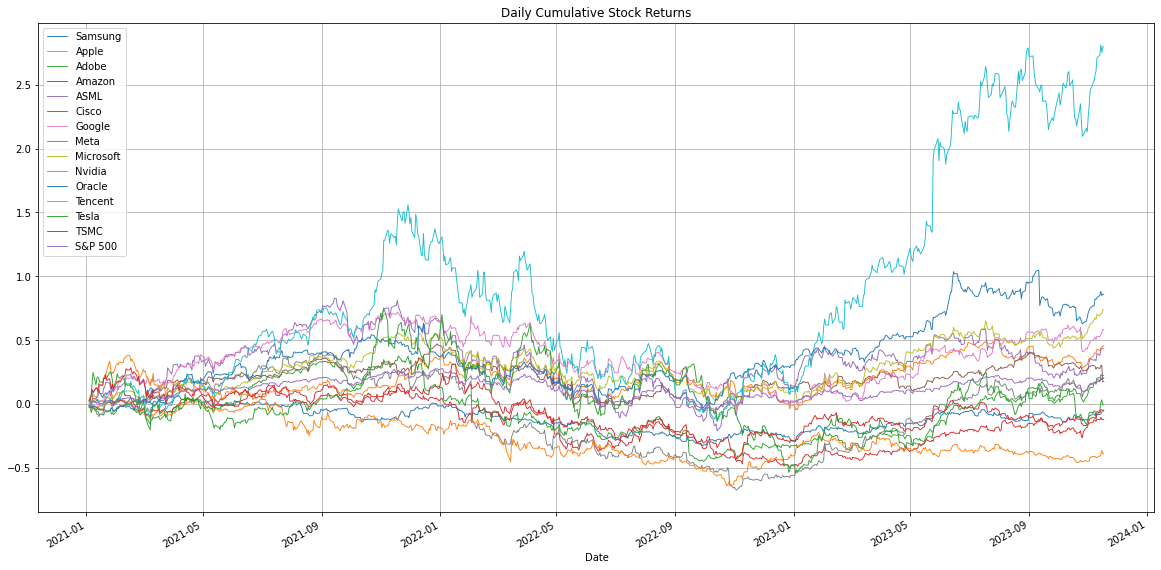

In [17]:
plot_start = datetime(2021, 1, 1)
plot_end = datetime(2023, 12, 31)
returns_plot = lib.read('hist_returns_clean', date_range=(plot_start, plot_end)).data
daily_cum_returns = ((1 + returns_plot).cumprod() - 1)
daily_cum_returns.rename(columns=symbols).plot(figsize=(20, 10), grid=True, linewidth=0.9, title="Daily Cumulative Stock Returns")

### Analysis: Compute Rolling Betas vs the S&P 500

Notice the big change in betas starting in Q2 2020 which rolls out of the betas 130 days later (the size of the rolling window).

Possibly due to the large market moves at the start of the Covid era?

In [18]:
index_ticker = "^GSPC"
roll_days = 130
beta_start = datetime(2018, 1, 1)
beta_end = datetime(2022, 12, 31)
beta_returns = lib.read('hist_returns_clean', date_range=(beta_start, beta_end)).data
index_returns = beta_returns[index_ticker]
stock_returns = beta_returns.drop(columns=index_ticker)

In [19]:
rolling_cov = stock_returns.rolling(roll_days).cov(index_returns).iloc[roll_days-1:]
rolling_index_var = index_returns.rolling(roll_days).var().iloc[roll_days-1:]
rolling_beta = rolling_cov.divide(rolling_index_var, axis='index').rename(columns=symbols)

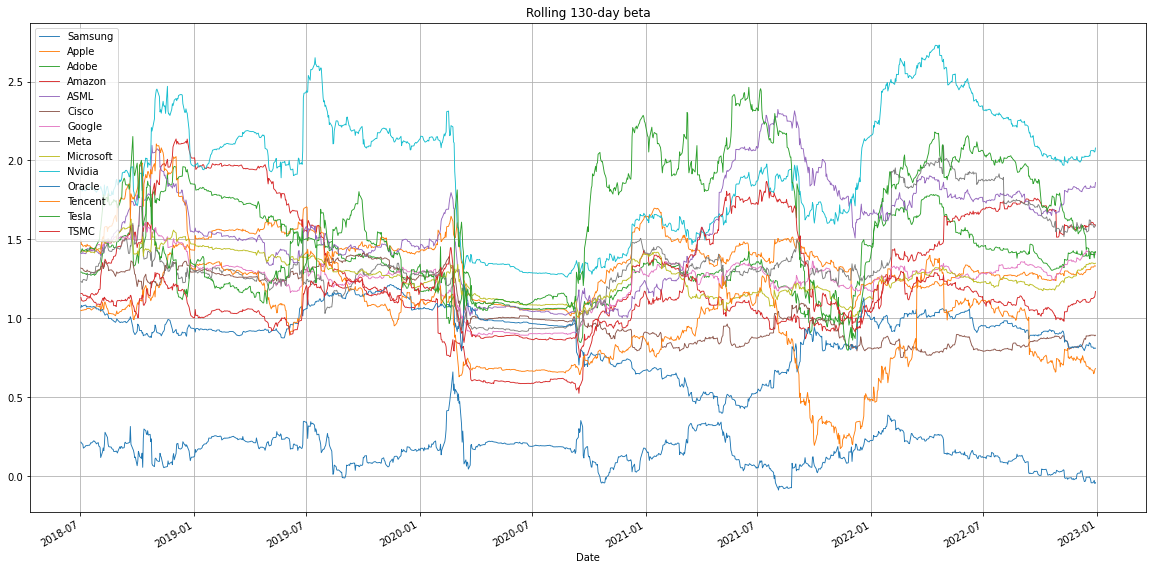

In [20]:
ax = rolling_beta.plot(figsize=(20, 10), grid=True, linewidth=0.9, title=f"Rolling {roll_days}-day beta")
ax.legend(loc='upper left')

### Conclusions

* We have demonstrated a simple data pipeline for capture and analysis
* Although simple, this pattern scales well to much larger datasets
* In a real system, the data collection and storage would be separated from the analysis
* Throughout the ArcticDB usage is simple, clean and clear
* Researchers and Data Scientists like the simplicity - it allows them to focus on the data and their research